Debugging Scenarios:

1 simulation only, passed through Augmented architecture

1 simulation only, passed with regularization (less wiggly?) - low priority

2 simulations only, distinguished by BStrength and iHelicity

2 or more fake simulations, with control over difference between two. eg scale and position around sun.

Fix potential bugs in formulation of edge Neural ODE, i.e. when doing the forward pass over the `ODEFunc`, ensure we return zeros for the latent dimension block of the vector, so it does not calculate gradients over those, try learning with only the ICs

In [2]:
run_tc1 = False
run_tc2 = True

In [3]:
import pandas as pd

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

In [5]:
import re
import os
import time

In [6]:
import matplotlib.pyplot as plt

In [7]:
%matplotlib inline

In [8]:
plt.rc("axes.spines", right=True, top=True)
plt.rc("figure", dpi=300, 
       figsize=(9, 3)
      )
plt.rc("font", family="serif")
plt.rc("legend", edgecolor="none", frameon=True)
plt.style.use("dark_background")

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [10]:
adjoint=True

In [11]:
!pip install --user -q torchdiffeq

In [12]:
if adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

In [13]:
import numpy as np
import scipy.linalg as la
import scipy.sparse as sparse
import matplotlib.pyplot as plt

In [14]:
%load_ext autoreload
%autoreload 2

In [15]:
import edge_utils as edut
import node_1d_utils as nut

In [16]:
ed_2161, sd_2161 = edut.load_edge_data_blobfree(2161)

In [17]:
theta_s_2161, theta_e_2161 = np.linspace(0, 360, 512)[160] + 1.2 * 180 - 360, np.linspace(0, 360, 512)[320] + 1.2 * 180 - 360
print("Range of angles for CR2161: {} {}".format(theta_s_2161, theta_e_2161))

Range of angles for CR2161: -31.279843444227026 81.44031311154595


In [18]:
nTimes, nTheta_2161, nSims_2161 = ed_2161.shape
nTimes, nTheta_2161, nSims_2161

(90, 160, 278)

In [19]:
theta_grid = np.linspace(np.ceil(theta_s_2161), np.ceil(theta_e_2161), nTheta_2161)

In [20]:
def getRValuesAllSims(edge_data_matrix):
    """
    Return r values for all sims at once so we don't lose time in training processing r values repeatedly
    """
    r_data_matrix = np.zeros(edge_data_matrix.shape)
    nsims = edge_data_matrix.shape[2]
    for i in range(nsims):
        r_vals, theta_vals = edut.getRValues(edge_data_matrix, simIdx=i, minStartIdx=0)
        r_data_matrix[:, :, i] = r_vals

    return r_data_matrix

In [21]:
rd_2161 = getRValuesAllSims(ed_2161)

In [22]:
plt.rc("axes.spines", right=True, top=True)
plt.rc("figure", dpi=300, 
       figsize=(9, 3)
      )
plt.rc("font", family="serif")
plt.rc("legend", edgecolor="none", frameon=True)
plt.style.use("dark_background")

In [23]:
import edge_utils as edut

In [24]:
# we are removing some data where the edge detection is not necessarily super reliable.
sims_to_remove = np.array([33, 39, 63, 73, 113, 128, 131, 142, 193, 218, 253, 264, 273, 312, 313, 324])

In [25]:
ed_2161, sd_2161 = edut.load_edge_data_blobfree(2161)

In [26]:
theta_s_2161, theta_e_2161 = np.linspace(0, 360, 512)[160] + 1.2 * 180 - 360, np.linspace(0, 360, 512)[320] + 1.2 * 180 - 360
print("Range of angles for CR2161: {} {}".format(theta_s_2161, theta_e_2161))

Range of angles for CR2161: -31.279843444227026 81.44031311154595


In [27]:
nTimes, nTheta_2161, nSims_2161 = ed_2161.shape
nTimes, nTheta_2161, nSims_2161

(90, 160, 278)

In [28]:
theta_grid = np.linspace(np.ceil(theta_s_2161), np.ceil(theta_e_2161), nTheta_2161)

In [29]:
sd_modified = np.setdiff1d(sd_2161, sims_to_remove)

In [30]:
len(sd_modified)

262

In [31]:
# extract training and test sets. for now just random.

from numpy.random import Generator, PCG64
rng = Generator(PCG64())

nTrain = int(np.floor(0.8 * len(sd_modified)))
nTest = len(sd_modified) - nTrain

nTrain, nTest

(209, 53)

In [32]:
sd_train = np.sort(np.random.choice(sd_modified, nTrain, replace=False))
sd_test = np.setdiff1d(sd_modified, sd_train)
sd_test

array([ 40,  53,  57,  66,  72,  76,  78,  81,  83,  90,  95, 108, 115,
       122, 129, 138, 139, 146, 150, 153, 156, 157, 166, 177, 179, 180,
       183, 186, 214, 220, 223, 224, 228, 229, 231, 232, 241, 247, 261,
       267, 268, 272, 278, 279, 281, 286, 296, 300, 317, 319, 320, 325,
       328])

In [33]:
sd_test.shape

(53,)

In [34]:
def getRValuesAllSims(edge_data_matrix):
    """
    Return r values for all sims at once so we don't lose time in training processing r values repeatedly
    """
    r_data_matrix = np.zeros(edge_data_matrix.shape)
    nsims = edge_data_matrix.shape[2]
    for i in range(nsims):
        r_vals, theta_vals = edut.getRValues(edge_data_matrix, simIdx=i, minStartIdx=0)
        r_data_matrix[:, :, i] = r_vals

    return r_data_matrix

In [35]:
rd_2161 = getRValuesAllSims(ed_2161)

### Set up for Parametrized and Regular Neural ODEs

In [36]:
cme_params_norm = pd.read_csv("./CMEParams2161_Scaled.csv", index_col=0)
cme_params_norm

,Radius,BStrength,ApexHeight,OrientationCme,iHelicity,realization,FactorB0,PoyntingFluxPerBSi,LperpTimesSqrtBSi
0,0.5675,0.420040,0.568916,0.5525,1.0,0.272727,0.120833,0.098542,0.436506
1,0.4525,0.057350,0.348039,0.1025,1.0,0.272727,0.120833,0.098542,0.436506
2,0.8525,0.014777,0.541725,0.8775,1.0,0.272727,0.120833,0.098542,0.436506
3,0.1225,0.323231,0.214567,0.5075,0.0,0.272727,0.120833,0.098542,0.436506
4,0.7825,0.085414,0.640815,0.3325,1.0,0.272727,0.120833,0.098542,0.436506
...,...,...,...,...,...,...,...,...,...
294,0.8750,0.252834,0.622193,0.1750,0.0,0.363636,0.352593,0.005643,0.937194
295,0.1250,0.655648,0.235434,0.4750,0.0,0.363636,0.352593,0.005643,0.937194
296,0.3250,0.518360,0.245710,0.7750,1.0,0.363636,0.352593,0.005643,0.937194
297,0.9250,0.289994,0.829820,0.6750,0.0,0.363636,0.352593,0.005643,0.937194


In [37]:
cme_params_to_augment = cme_params_norm.to_numpy()
cme_params_to_augment.shape

(278, 9)

### Setup for parametrized and regular NODE architecture (regular node will only handle one sim at a time)

Our first test case will involve passing 1 augmented simulation to PNODE and the same simulation sans parameters to NODE, and we compare their performance.

In [38]:
param_dim = cme_params_to_augment.shape[1]
param_dim

9

In [39]:
# now augment dataset with these scaled values.
rd_2161.shape

(90, 160, 278)

In [40]:
data_dim = rd_2161.shape[1]
data_dim

160

In [41]:
input_dim = rd_2161.shape[1]
input_dim, param_dim

(160, 9)

In [42]:
augmented_r = np.zeros((rd_2161.shape[0], data_dim + param_dim, rd_2161.shape[2]))
augmented_r[:, :(data_dim), :] = rd_2161
for iii in range(rd_2161.shape[2]):
    augmented_r[:, (data_dim):, iii] = cme_params_to_augment[iii, :]

In [43]:
augmented_r.shape

(90, 169, 278)

In [44]:
class PNODE(nn.Module):

    def __init__(self, input_dim, param_dim, n_layers=1, n_units=100):
        super(PNODE, self).__init__()

        self.net1 = nn.Sequential(
            nn.Linear(input_dim + param_dim, n_units),
            nn.Tanh(),
            nn.Linear(n_units, n_units),
            nn.Tanh(),
            nn.Linear(n_units, input_dim)
        )
        
        for m in self.net1.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    # def set_params(self, new_params):
    #     self.params = new_params

    def forward(self, t, y):
        
        
        # y_ip = y[:, :, :input_dim]
        
        # with torch.set_grad_enabled(True):
            # y_ip.requires_grad_(True)
        output = torch.cat((self.net1(y),
                            torch.zeros_like(y[:, :, input_dim:])), -1)
        
        # y2 = y.clone()
        # y2[:, :, input_dim:] = self.params
        # output = torch.cat((self.net1(y2),
                            # torch.zeros_like(self.params)),-1)
        return output

In [46]:
class NODE(nn.Module):

    def __init__(self, input_dim, n_layers=1, n_units=100):
        super(NODE, self).__init__()

        self.net1 = nn.Sequential(
            nn.Linear(input_dim, n_units),
            nn.Tanh(),
            nn.Linear(n_units, n_units),
            nn.Tanh(),
            nn.Linear(n_units, input_dim)
        )
        
        for m in self.net1.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):        
        # y_ip = y[:, :, :input_dim]
        
        # with torch.set_grad_enabled(True):
            # y_ip.requires_grad_(True)
            # output = self.net1(y_ip)

        output = self.net1(y)
        return output

In [47]:
y01, yt1, yf1, tt1, ts1, si1 = nut.getDataForSim(ed_2161, augmented_r, sd_2161, 31)

In [48]:
y01.shape, yt1.shape

(torch.Size([1, 169]), torch.Size([46, 1, 169]))

In [49]:
my_node = NODE(input_dim).to(device)
my_pnode = PNODE(input_dim, param_dim).to(device)

opt_node = optim.Adam(my_node.parameters(), lr=1e-3)
opt_pnode = optim.Adam(my_pnode.parameters(), lr=1e-3)

In [50]:
my_node, my_pnode

(NODE(
   (net1): Sequential(
     (0): Linear(in_features=160, out_features=100, bias=True)
     (1): Tanh()
     (2): Linear(in_features=100, out_features=100, bias=True)
     (3): Tanh()
     (4): Linear(in_features=100, out_features=160, bias=True)
   )
 ),
 PNODE(
   (net1): Sequential(
     (0): Linear(in_features=169, out_features=100, bias=True)
     (1): Tanh()
     (2): Linear(in_features=100, out_features=100, bias=True)
     (3): Tanh()
     (4): Linear(in_features=100, out_features=160, bias=True)
   )
 ))

### Test Case 1: Pass 1 sim through NODE and PNODE.

(Sims 231, 234, 241)

In [55]:
tc1_sims = np.array([231, 234, 241])

In [52]:
y0_train_torch_231, y_train_torch_231, y_full_torch_231, t_train_torch_231, t_scaled_torch_231, sim_index_231 = nut.getDataForSim(ed_2161,augmented_r,sd_2161,231)
y0_train_torch_234, y_train_torch_234, y_full_torch_234, t_train_torch_234, t_scaled_torch_234, sim_index_234 = nut.getDataForSim(ed_2161,augmented_r,sd_2161,234)
y0_train_torch_241, y_train_torch_241, y_full_torch_241, t_train_torch_241, t_scaled_torch_241, sim_index_241 = nut.getDataForSim(ed_2161,augmented_r,sd_2161,241)

In [57]:
y0_train_torch_231.shape

torch.Size([1, 169])

In [58]:
# y_train_torch_231[:, 0, input_dim:]

In [59]:
# corresponding CME parameters?

In [60]:
cme_params_tc1 = cme_params_norm.loc[tc1_sims - 30 - 1]
cme_params_tc1

,Radius,BStrength,ApexHeight,OrientationCme,iHelicity,realization,FactorB0,PoyntingFluxPerBSi,LperpTimesSqrtBSi
200,0.725,0.030838,0.640625,0.225,1.0,0.272727,0.120833,0.098542,0.436506
203,0.825,0.073683,0.824523,0.575,1.0,0.272727,0.120833,0.098542,0.436506
210,0.075,0.527969,0.100265,0.025,0.0,0.272727,0.120833,0.098542,0.436506


In [61]:
input_dim

160

In [62]:
by0, bt, by = nut.get_batch(y_train_torch_231, t_train_torch_231)

In [63]:
by0.shape, bt.shape, by.shape

(torch.Size([10, 1, 169]), torch.Size([10, 5]), torch.Size([5, 10, 1, 169]))

In [64]:
# try passing through node and pnode once to verify forward pass works.
tt = 0.5
my_node(tt, by0[:, :, :input_dim]).shape, my_pnode(tt, by0).shape

(torch.Size([10, 1, 160]), torch.Size([10, 1, 169]))

In [65]:
# also try passing through odeint to see if the integration works.
odeint(my_node, by0[:, :, :input_dim], bt[1, :]).shape, odeint(my_pnode, by0, bt[1, :]).shape

(torch.Size([5, 10, 1, 160]), torch.Size([5, 10, 1, 169]))

In [66]:
# by0[[0], :, :].shape

In [67]:
# odeint(func, torch.unsqueeze(y0_train_torch_231, 0), t_scaled_torch_231).shape

In [68]:
sim_iters = 500
test_freq = 5

In [69]:
batch_time = 5
batch_size = 10

In [73]:
if run_tc1:
    # for each_sim in tc1_sims:
        y0_train_torch, y_train_torch, y_full_torch, t_train_torch, t_scaled_torch, sim_index = nut.getDataForSim(ed_2161,augmented_r,sd_2161,231)
        for itr in range(1, sim_iters + 1):
            opt_node.zero_grad()
            opt_pnode.zero_grad()

            batch_y0, batch_t, batch_y = nut.get_batch(y_train_torch, t_train_torch, batch_time=batch_time, batch_size=batch_size)
            pred_y_node = torch.zeros_like(batch_y[:, :, :, :input_dim])
            pred_y_pnode = torch.zeros_like(batch_y)
            
            for i in range(batch_size):
                pred_y_node[:, i, :, :] =  torch.squeeze(odeint(my_node, batch_y0[[i], :, :input_dim], batch_t[i, :]), 1).to(device)
                pred_y_pnode[:, i, :, :] = torch.squeeze(odeint(my_pnode, batch_y0[[i], :, :], batch_t[i, :]), 1).to(device)
                
                
            loss_node = torch.mean(torch.abs(pred_y_node - batch_y[:, :, :, :input_dim]))
            loss_pnode = torch.mean(torch.abs(pred_y_pnode[:, :, :, :input_dim] - batch_y[:, :, :, :input_dim]))
            
            loss_node.backward()
            loss_pnode.backward()
            
            opt_node.step()
            opt_pnode.step()

            if itr % test_freq == 0:
                with torch.no_grad():
                    pred_y_full_series_231_node = odeint(my_node, torch.unsqueeze(y0_train_torch_231[:, :input_dim], 0), t_scaled_torch_231)
                    pred_y_full_series_231_pnode = odeint(my_pnode, torch.unsqueeze(y0_train_torch_231, 0), t_scaled_torch_231)
                    
                    loss_node_full = torch.mean(torch.abs(pred_y_full_series_231_node - torch.unsqueeze(y_full_torch_231, 1)[:, :, :, :input_dim]))
                    loss_pnode_full = torch.mean(torch.abs(pred_y_full_series_231_pnode[:, :, :, :input_dim] - torch.unsqueeze(y_full_torch_231, 1)[:, :, :, :input_dim]))

                    print("Iter {:04d} | Total Loss NODE PNODE {:.6f} {:.6f} ".format(itr,
                                                                                    loss_node_full.item(), 
                                                                                    loss_pnode_full.item(),
                                                                                    ))

Iter 0005 | Total Loss NODE PNODE 3.051403 3.003410 
Iter 0010 | Total Loss NODE PNODE 2.831242 2.756031 
Iter 0015 | Total Loss NODE PNODE 2.577538 2.489766 
Iter 0020 | Total Loss NODE PNODE 2.305187 2.222131 
Iter 0025 | Total Loss NODE PNODE 2.027552 1.956704 
Iter 0030 | Total Loss NODE PNODE 1.753692 1.695668 
Iter 0035 | Total Loss NODE PNODE 1.489902 1.444108 
Iter 0040 | Total Loss NODE PNODE 1.237482 1.206024 
Iter 0045 | Total Loss NODE PNODE 1.004558 0.980863 
Iter 0050 | Total Loss NODE PNODE 0.793991 0.775856 
Iter 0055 | Total Loss NODE PNODE 0.606981 0.602645 
Iter 0060 | Total Loss NODE PNODE 0.455048 0.464945 
Iter 0065 | Total Loss NODE PNODE 0.342580 0.369373 
Iter 0070 | Total Loss NODE PNODE 0.269878 0.299733 
Iter 0075 | Total Loss NODE PNODE 0.224097 0.250033 
Iter 0080 | Total Loss NODE PNODE 0.203251 0.219166 
Iter 0085 | Total Loss NODE PNODE 0.199033 0.202907 
Iter 0090 | Total Loss NODE PNODE 0.198952 0.197062 
Iter 0095 | Total Loss NODE PNODE 0.190000 0.1

In [75]:
if run_tc1:
    with torch.no_grad():
        pred_y_node_final = odeint(my_node, torch.unsqueeze(y0_train_torch_231[:, :input_dim], 0), t_scaled_torch_231)
        pred_y_pnode_final = odeint(my_pnode, torch.unsqueeze(y0_train_torch_231, 0), t_scaled_torch_231)
        
    pred_y_node_final = torch.squeeze(pred_y_node_final)
    pred_y_pnode_final = torch.squeeze(pred_y_pnode_final)[:, :input_dim]

In [76]:
pred_y_node_final.shape, pred_y_pnode_final.shape

(torch.Size([64, 160]), torch.Size([64, 160]))

In [80]:
y_true_231 = torch.squeeze(y_full_torch_231)[:, :input_dim]

In [81]:
y_true_231.shape

torch.Size([64, 160])

In [82]:
sd_2161[186]

231

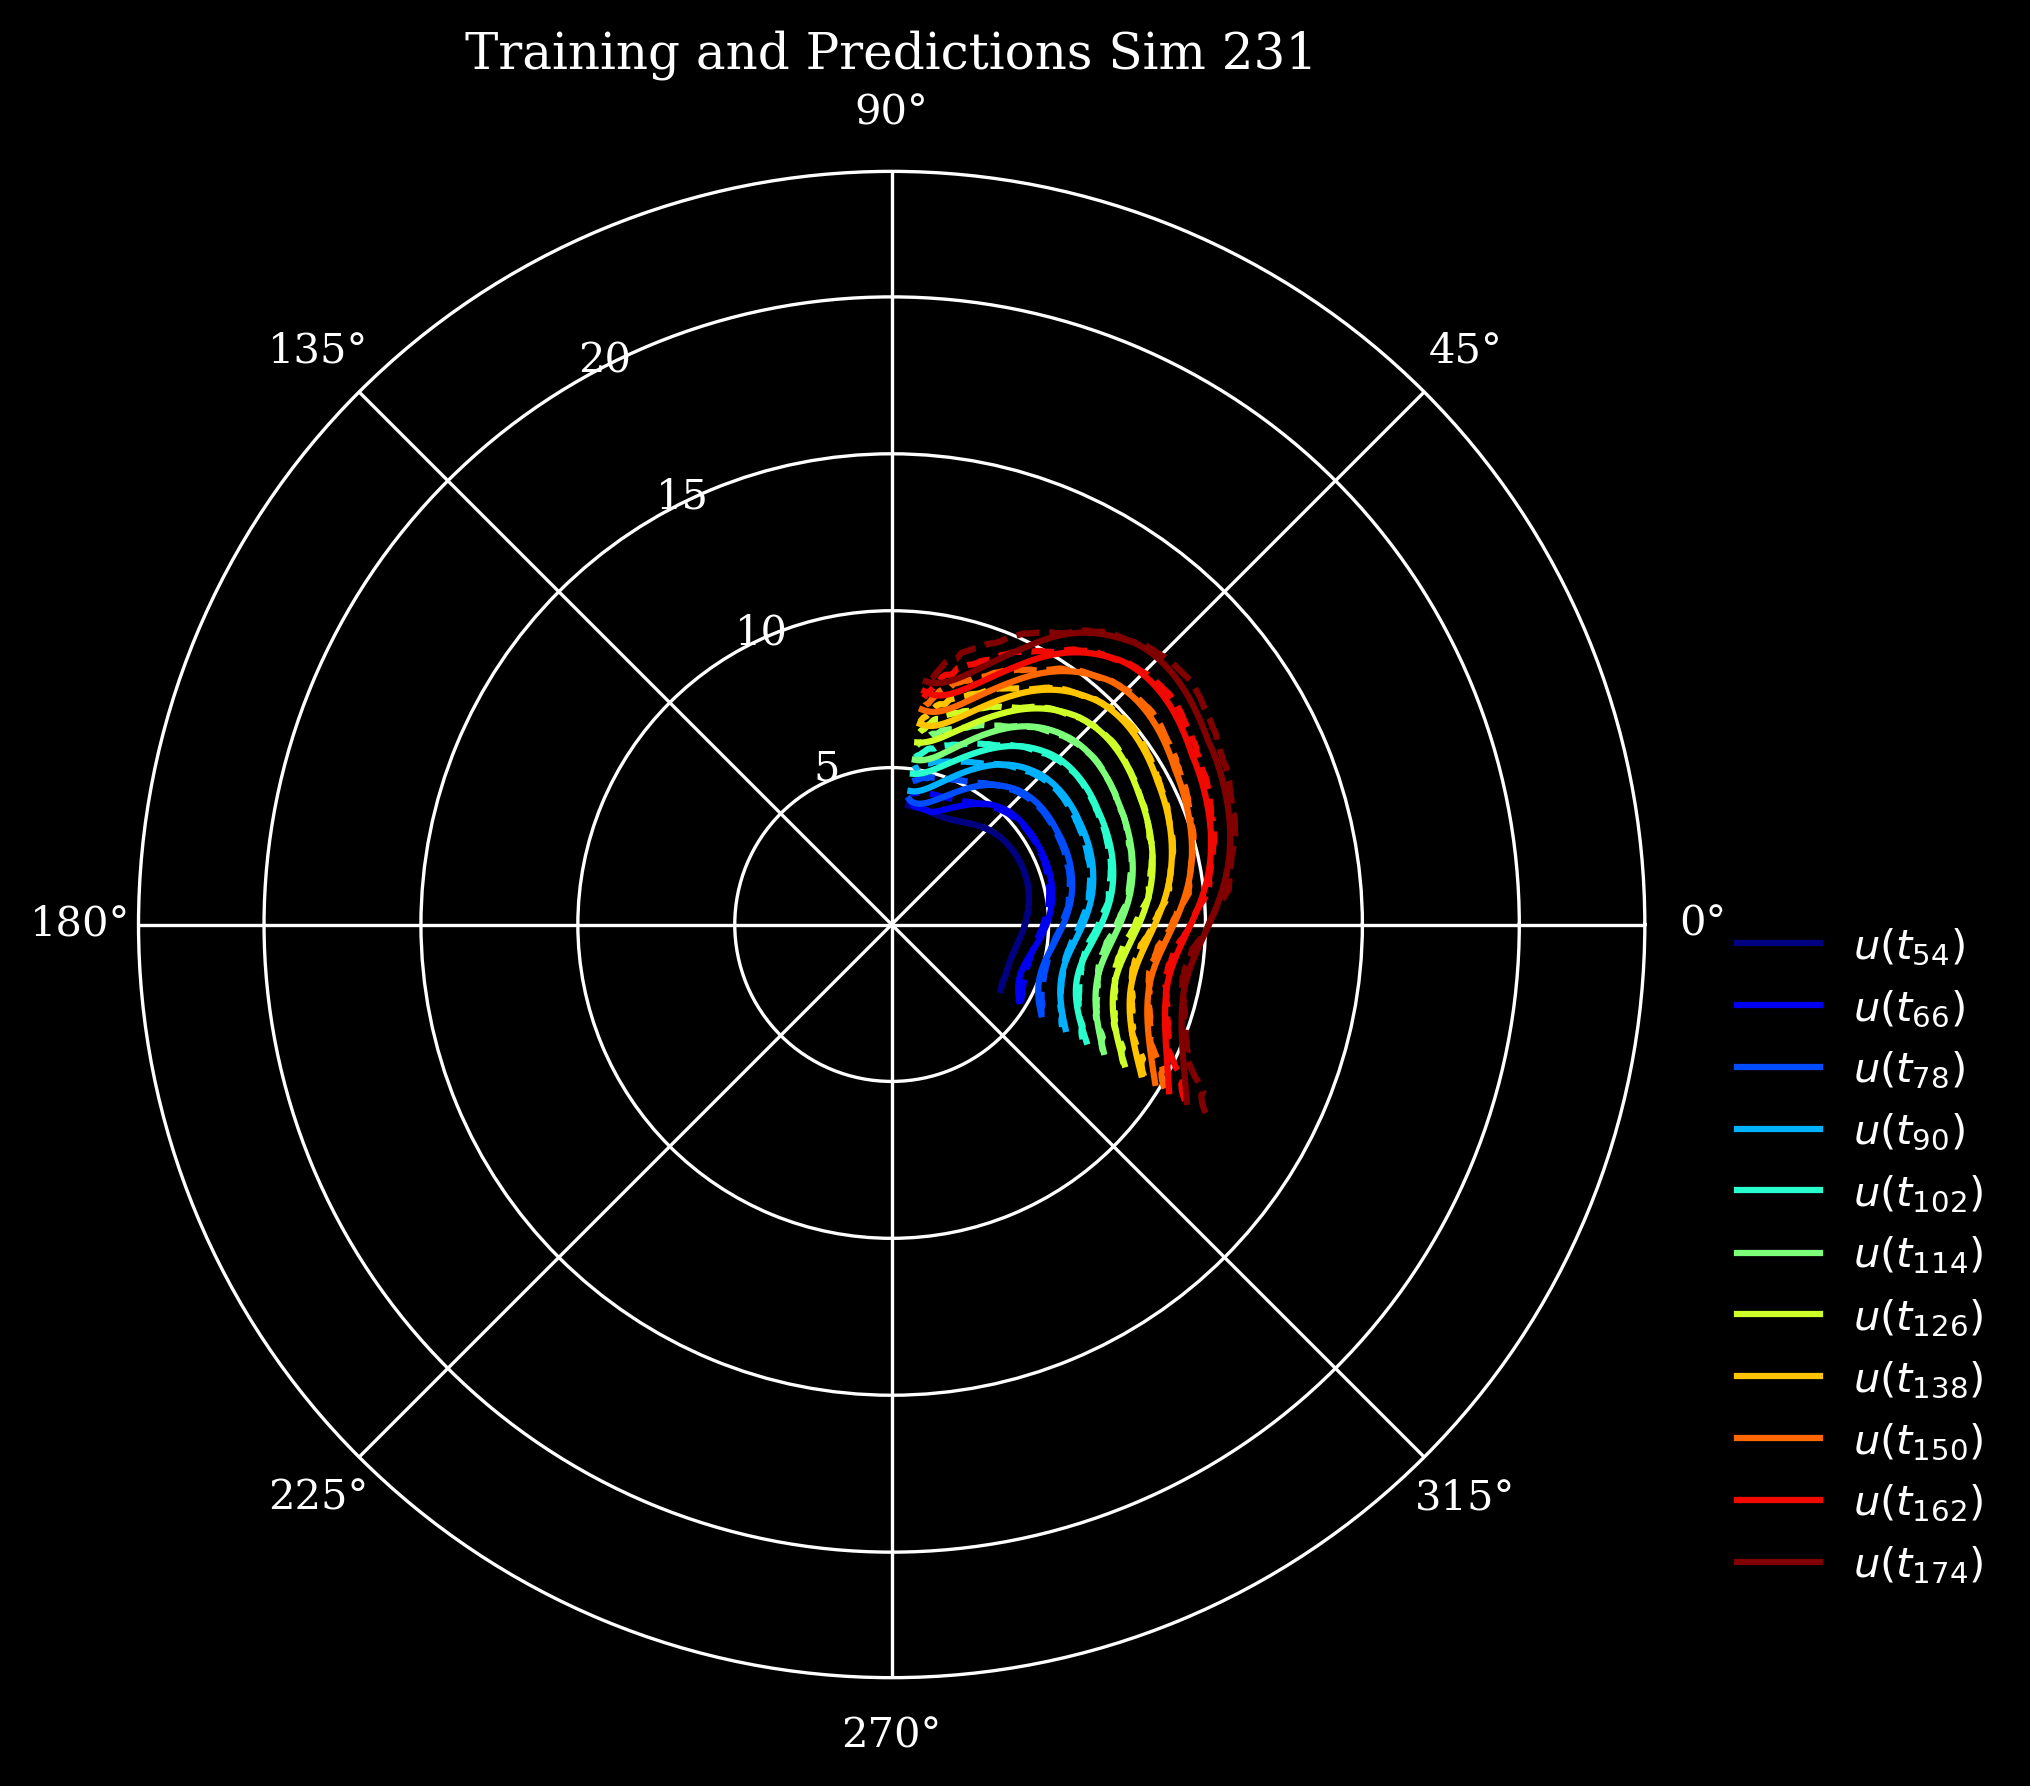

In [83]:
edut.plotTrainPredData1Model(y_true_231.cpu().numpy(), pred_y_node_final.cpu().numpy(), ed_2161, sd_2161, simIdx=186)

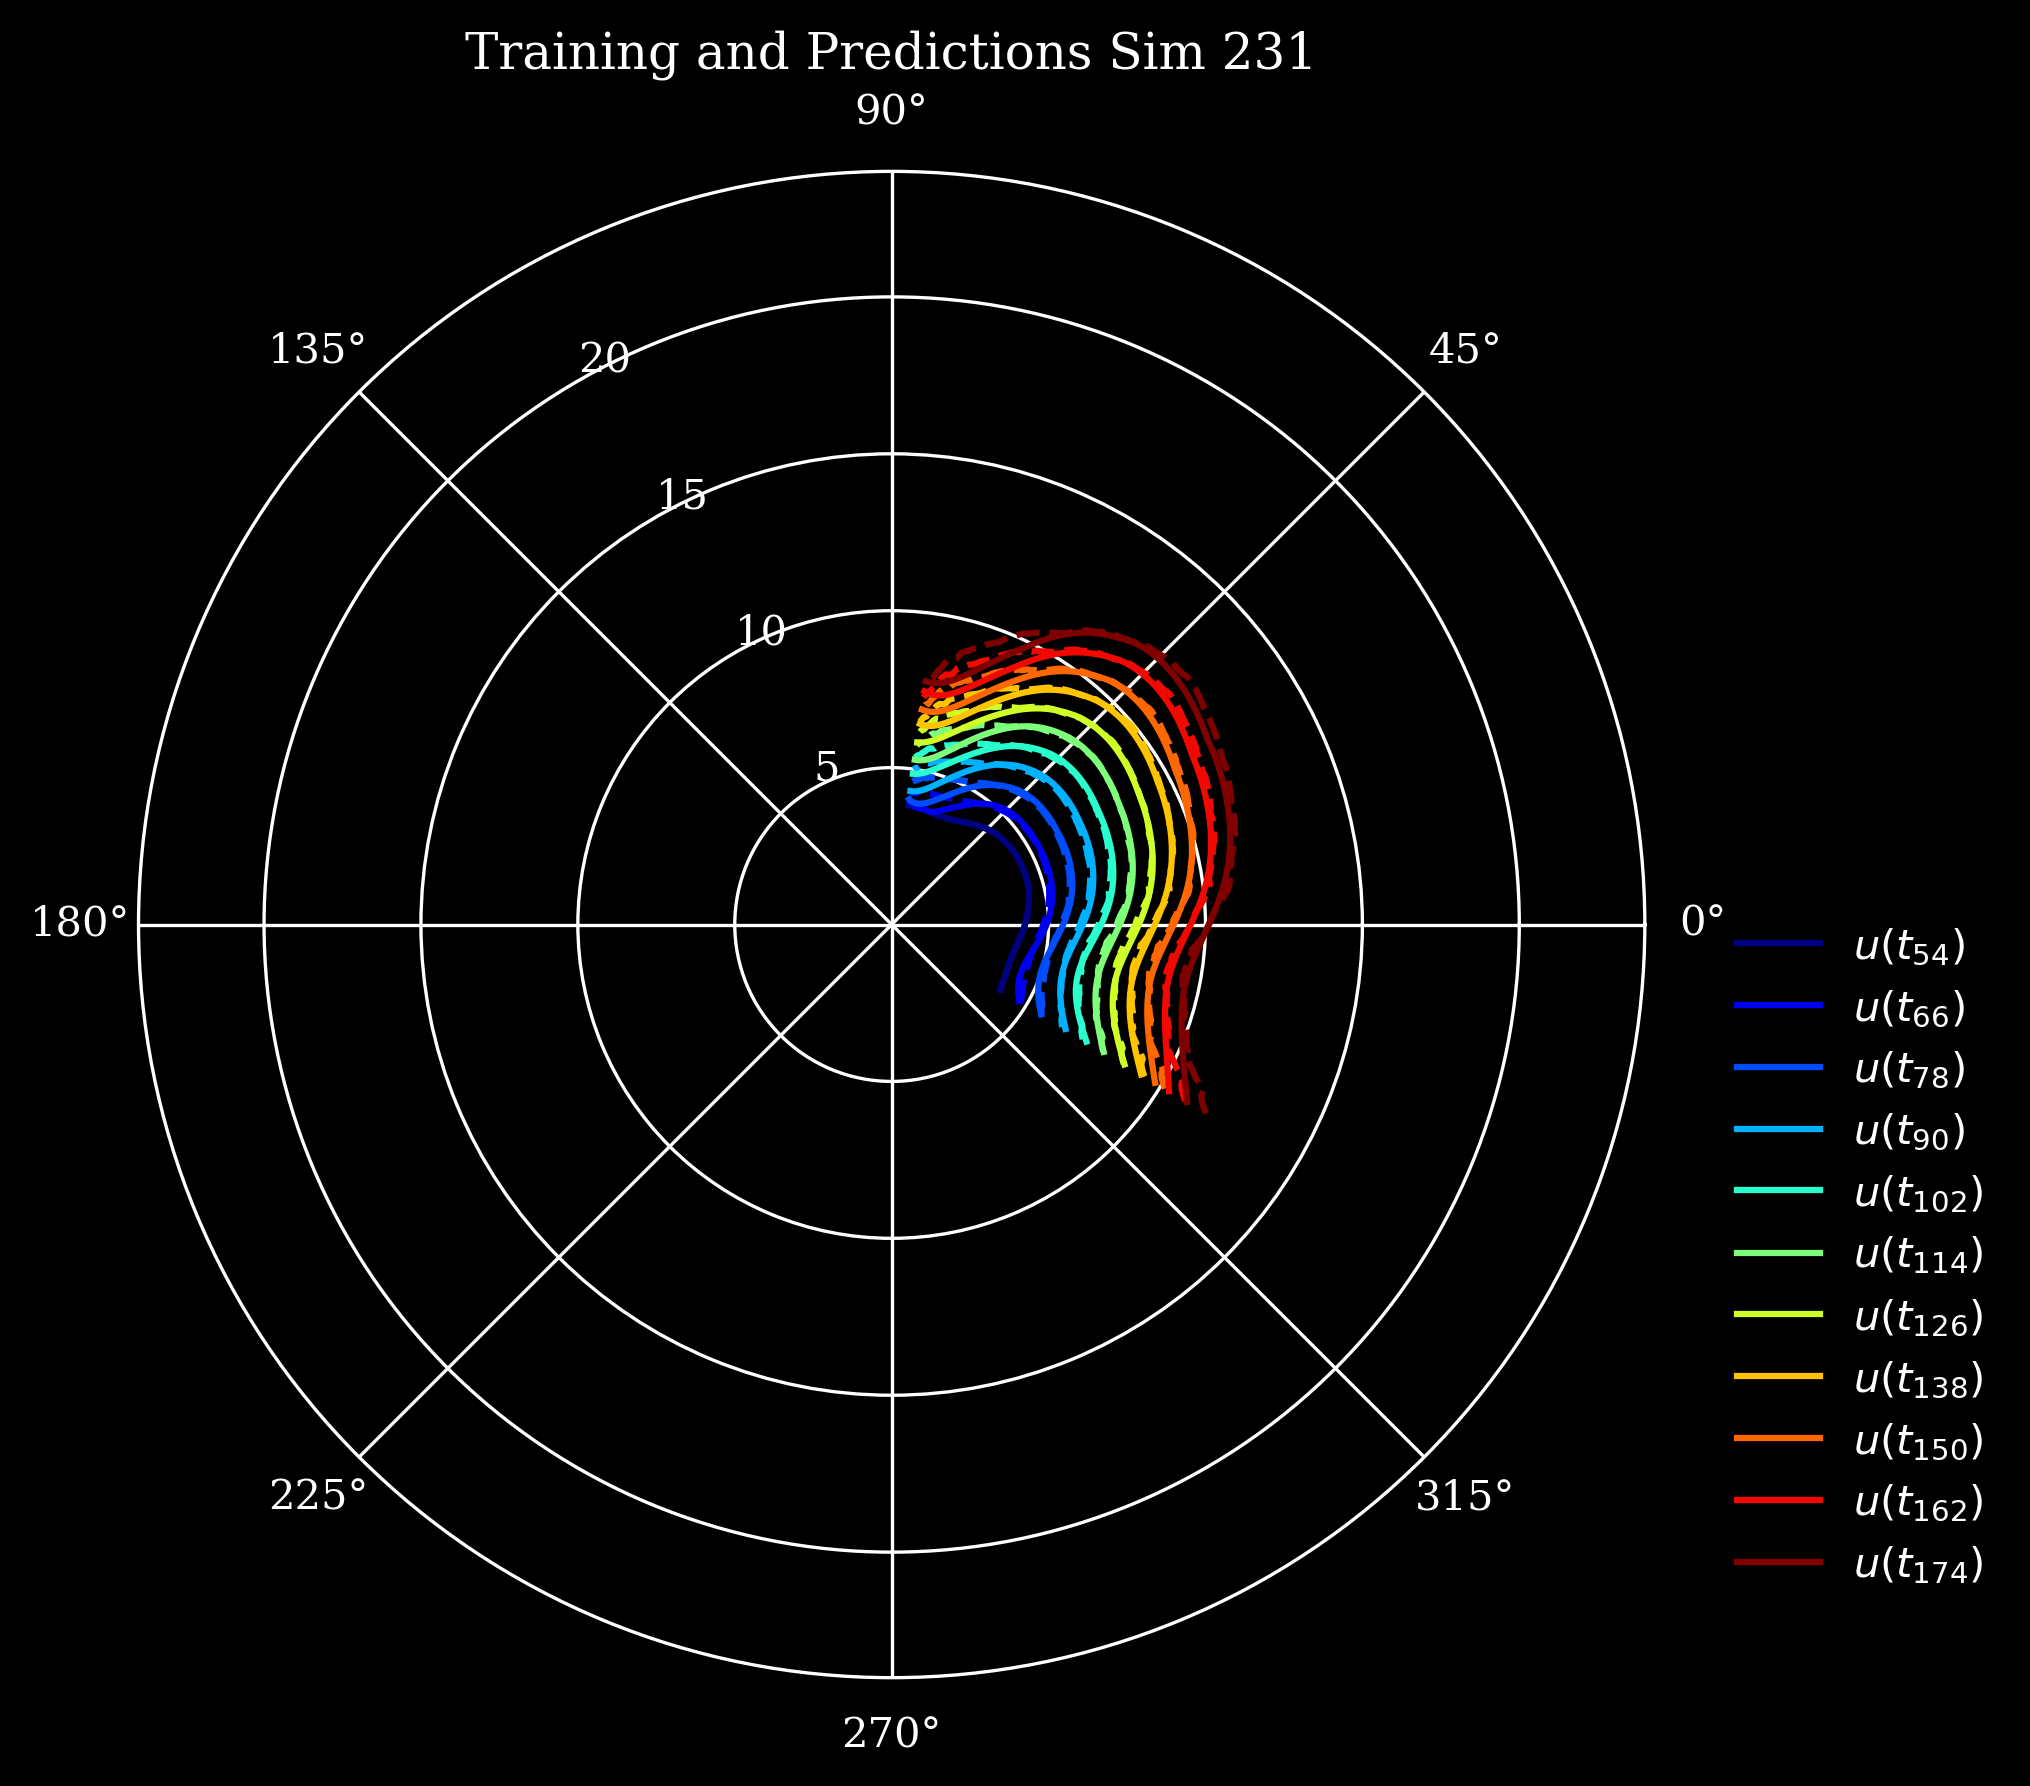

In [84]:
edut.plotTrainPredData1Model(y_true_231.cpu().numpy(), pred_y_pnode_final.cpu().numpy(), ed_2161, sd_2161, simIdx=186)

**Test Case 2: Run 2 sims, say 231 and 234. Supply only BStrength and iHelicity as inputs to PNODE?**

In [89]:
# we use only BStrength, iHelicity and dt of the sim? as parameters.

In [53]:
t_train_torch_231

tensor([0.0000, 0.0159, 0.0317, 0.0476, 0.0635, 0.0794, 0.0952, 0.1111, 0.1270,
        0.1429, 0.1587, 0.1746, 0.1905, 0.2063, 0.2222, 0.2381, 0.2540, 0.2698,
        0.2857, 0.3016, 0.3175, 0.3333, 0.3492, 0.3651, 0.3810, 0.3968, 0.4127,
        0.4286, 0.4444, 0.4603, 0.4762, 0.4921, 0.5079, 0.5238, 0.5397, 0.5556,
        0.5714, 0.5873, 0.6032, 0.6190, 0.6349, 0.6508, 0.6667],
       device='cuda:0')

In [54]:
t_train_torch_234

tensor([0.0000, 0.0145, 0.0290, 0.0435, 0.0580, 0.0725, 0.0870, 0.1014, 0.1159,
        0.1304, 0.1449, 0.1594, 0.1739, 0.1884, 0.2029, 0.2174, 0.2319, 0.2464,
        0.2609, 0.2754, 0.2899, 0.3043, 0.3188, 0.3333, 0.3478, 0.3623, 0.3768,
        0.3913, 0.4058, 0.4203, 0.4348, 0.4493, 0.4638, 0.4783, 0.4928, 0.5072,
        0.5217, 0.5362, 0.5507, 0.5652, 0.5797, 0.5942, 0.6087, 0.6232, 0.6377,
        0.6522, 0.6667], device='cuda:0')

In [55]:
cme_params_norm[["BStrength", "iHelicity"]]

,BStrength,iHelicity
0,0.420040,1.0
1,0.057350,1.0
2,0.014777,1.0
3,0.323231,0.0
4,0.085414,1.0
...,...,...
294,0.252834,0.0
295,0.655648,0.0
296,0.518360,1.0
297,0.289994,0.0


In [63]:
cme_params_tc2 = cme_params_norm.loc[np.array([231, 234]) - 30 - 1][["BStrength", "iHelicity"]]
cme_params_tc2["delta_t"] = [(t_train_torch_231.cpu()[1] - t_train_torch_231.cpu()[0]).item(), (t_train_torch_234.cpu()[1] - t_train_torch_234.cpu()[0]).item()]
cme_params_tc2

,BStrength,iHelicity,delta_t
200,0.030838,1.0,0.015873
203,0.073683,1.0,0.014493


In [68]:
cme_params_augment_tc2 = torch.Tensor(cme_params_tc2.to_numpy()).to(device)
cme_params_augment_tc2

tensor([[0.0308, 1.0000, 0.0159],
        [0.0737, 1.0000, 0.0145]], device='cuda:0')

In [77]:
cme_params_augment_tc2[[1], :].repeat(4, 1)

tensor([[0.0737, 1.0000, 0.0145],
        [0.0737, 1.0000, 0.0145],
        [0.0737, 1.0000, 0.0145],
        [0.0737, 1.0000, 0.0145]], device='cuda:0')

In [86]:
y_train_torch_234.shape

torch.Size([47, 1, 169])

In [146]:
y0_train_torch_231_tc2 = y0_train_torch_231[:, :input_dim]
y0_train_torch_231_tc2 = torch.cat((y0_train_torch_231_tc2, cme_params_augment_tc2[[0], :]), 1)

y_train_torch_231_tc2 = y_train_torch_231[:, :, :input_dim]
y_train_torch_231_tc2 = torch.cat((y_train_torch_231_tc2, torch.unsqueeze(cme_params_augment_tc2[[0], :].repeat(43, 1), 1)), 2)

y_full_torch_231_tc2 = y_full_torch_231[:, :, :input_dim]
y_full_torch_231_tc2 = torch.cat((y_full_torch_231_tc2, torch.unsqueeze(cme_params_augment_tc2[[0], :].repeat(64, 1), 1)), 2)



y0_train_torch_234_tc2 = y0_train_torch_234[:, :input_dim]
y0_train_torch_234_tc2 = torch.cat((y0_train_torch_234_tc2, cme_params_augment_tc2[[1], :]), 1)

y_train_torch_234_tc2 = y_train_torch_234[:, :, :input_dim]
y_train_torch_234_tc2 = torch.cat((y_train_torch_234_tc2, torch.unsqueeze(cme_params_augment_tc2[[1], :].repeat(47, 1), 1)), 2)

y_full_torch_234_tc2 = y_full_torch_234[:, :, :input_dim]
y_full_torch_234_tc2 = torch.cat((y_full_torch_234_tc2, torch.unsqueeze(cme_params_augment_tc2[[1], :].repeat(70, 1), 1)), 2)

y0_train_torch_231_tc2.shape, y_train_torch_231_tc2.shape, y_full_torch_231_tc2.shape, y0_train_torch_234_tc2.shape, y_train_torch_234_tc2.shape, y_full_torch_234_tc2.shape

(torch.Size([1, 163]),
 torch.Size([43, 1, 163]),
 torch.Size([64, 1, 163]),
 torch.Size([1, 163]),
 torch.Size([47, 1, 163]),
 torch.Size([70, 1, 163]))

In [147]:
t_train_torch_231.shape, t_train_torch_234.shape

(torch.Size([43]), torch.Size([47]))

In [148]:
t_scaled_torch_231.shape, t_scaled_torch_234.shape

(torch.Size([64]), torch.Size([70]))

In [149]:
my_pnode_2 = PNODE(input_dim, 3).to(device)
opt_pnode_2 = optim.Adam(my_pnode_2.parameters(), lr=1e-3)

In [150]:
my_pnode_2

PNODE(
  (net1): Sequential(
    (0): Linear(in_features=163, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Tanh()
    (4): Linear(in_features=100, out_features=160, bias=True)
  )
)

In [151]:
sim_iters = 500
test_freq = 5

batch_time = 5
batch_size = 10

In [152]:
if run_tc2:
    for sim_chosen in np.array([231, 234]):
        for itr in range(1, sim_iters + 1):
            opt_pnode_2.zero_grad()

            # sim_chosen = np.random.choice([231, 234])

            if sim_chosen == 231:
                batch_y0, batch_t, batch_y = nut.get_batch(y_train_torch_231_tc2, t_train_torch_231, batch_time=batch_time, batch_size=batch_size)
            elif sim_chosen == 234:
                batch_y0, batch_t, batch_y = nut.get_batch(y_train_torch_234_tc2, t_train_torch_234, batch_time=batch_time, batch_size=batch_size)


            pred_y_pnode = torch.zeros_like(batch_y)

            for i in range(batch_size):
                # pred_y_node[:, i, :, :] =  torch.squeeze(odeint(my_node, batch_y0[[i], :, :input_dim], batch_t[i, :]), 1).to(device)
                pred_y_pnode[:, i, :, :] = torch.squeeze(odeint(my_pnode_2, batch_y0[[i], :, :], batch_t[i, :]), 1).to(device)


            # loss_node = torch.mean(torch.abs(pred_y_node - batch_y[:, :, :, :input_dim]))
            loss_pnode = torch.mean(torch.abs(pred_y_pnode[:, :, :, :input_dim] - batch_y[:, :, :, :input_dim]))

            # loss_node.backward()
            loss_pnode.backward()

            # opt_node.step()
            opt_pnode_2.step()

            if itr % test_freq == 0:
                with torch.no_grad():
                    # pred_y_full_series_231_node = odeint(my_node, torch.unsqueeze(y0_train_torch_231[:, :input_dim], 0), t_scaled_torch_231)
                    # if sim_chosen == 231:
                    pred_y_full_series_pnode_231 = odeint(my_pnode_2, torch.unsqueeze(y0_train_torch_231_tc2, 0), t_scaled_torch_231)
                    loss_pnode_full_231 = torch.mean(torch.abs(pred_y_full_series_pnode_231[:, :, :, :input_dim] - torch.unsqueeze(y_full_torch_231_tc2, 1)[:, :, :, :input_dim]))

                    # elif sim_chosen == 234:
                    pred_y_full_series_pnode_234 = odeint(my_pnode_2, torch.unsqueeze(y0_train_torch_234_tc2, 0), t_scaled_torch_234)
                    loss_pnode_full_234 = torch.mean(torch.abs(pred_y_full_series_pnode_234[:, :, :, :input_dim] - torch.unsqueeze(y_full_torch_234_tc2, 1)[:, :, :, :input_dim]))


                    print("Iter {:04d} | Sim {:03d} Loss PNODE {:.6f} | Sim {:03d} Loss PNODE {:.6f}".format(itr,
                                                                                                             231,
                                                                                                             loss_pnode_full_231.item(),
                                                                                                             234,
                                                                                                             loss_pnode_full_234.item(),
                                                                                                            ))

Iter 0005 | Sim 231 Loss PNODE 3.094718 | Sim 234 Loss PNODE 3.959231
Iter 0010 | Sim 231 Loss PNODE 2.874645 | Sim 234 Loss PNODE 3.738230
Iter 0015 | Sim 231 Loss PNODE 2.630682 | Sim 234 Loss PNODE 3.491934
Iter 0020 | Sim 231 Loss PNODE 2.362550 | Sim 234 Loss PNODE 3.220747
Iter 0025 | Sim 231 Loss PNODE 2.090751 | Sim 234 Loss PNODE 2.944573
Iter 0030 | Sim 231 Loss PNODE 1.822720 | Sim 234 Loss PNODE 2.670667
Iter 0035 | Sim 231 Loss PNODE 1.558756 | Sim 234 Loss PNODE 2.397775
Iter 0040 | Sim 231 Loss PNODE 1.303207 | Sim 234 Loss PNODE 2.131302
Iter 0045 | Sim 231 Loss PNODE 1.062600 | Sim 234 Loss PNODE 1.875668
Iter 0050 | Sim 231 Loss PNODE 0.844815 | Sim 234 Loss PNODE 1.632120
Iter 0055 | Sim 231 Loss PNODE 0.663368 | Sim 234 Loss PNODE 1.410439
Iter 0060 | Sim 231 Loss PNODE 0.516022 | Sim 234 Loss PNODE 1.220302
Iter 0065 | Sim 231 Loss PNODE 0.408969 | Sim 234 Loss PNODE 1.065152
Iter 0070 | Sim 231 Loss PNODE 0.329708 | Sim 234 Loss PNODE 0.954871
Iter 0075 | Sim 231 

In [136]:
if run_tc2:
    with torch.no_grad():
        # pred_y_node_final = odeint(my_node, torch.unsqueeze(y0_train_torch_231[:, :input_dim], 0), t_scaled_torch_231)
        pred_y_pnode_final_231 = odeint(my_pnode_2, torch.unsqueeze(y0_train_torch_231_tc2, 0), t_scaled_torch_231)
        pred_y_pnode_final_234 = odeint(my_pnode_2, torch.unsqueeze(y0_train_torch_234_tc2, 0), t_scaled_torch_234)
        
        
    pred_y_pnode_final_231 = torch.squeeze(pred_y_pnode_final_231)[:, :input_dim]
    pred_y_pnode_final_234 = torch.squeeze(pred_y_pnode_final_234)[:, :input_dim]

In [137]:
sd_2161[186], sd_2161[189]

(231, 234)

In [138]:
y_true_231 = torch.squeeze(y_full_torch_231_tc2)[:, :input_dim]
y_true_234 = torch.squeeze(y_full_torch_234_tc2)[:, :input_dim]

In [139]:
y_true_231.shape, y_true_234.shape

(torch.Size([64, 160]), torch.Size([70, 160]))

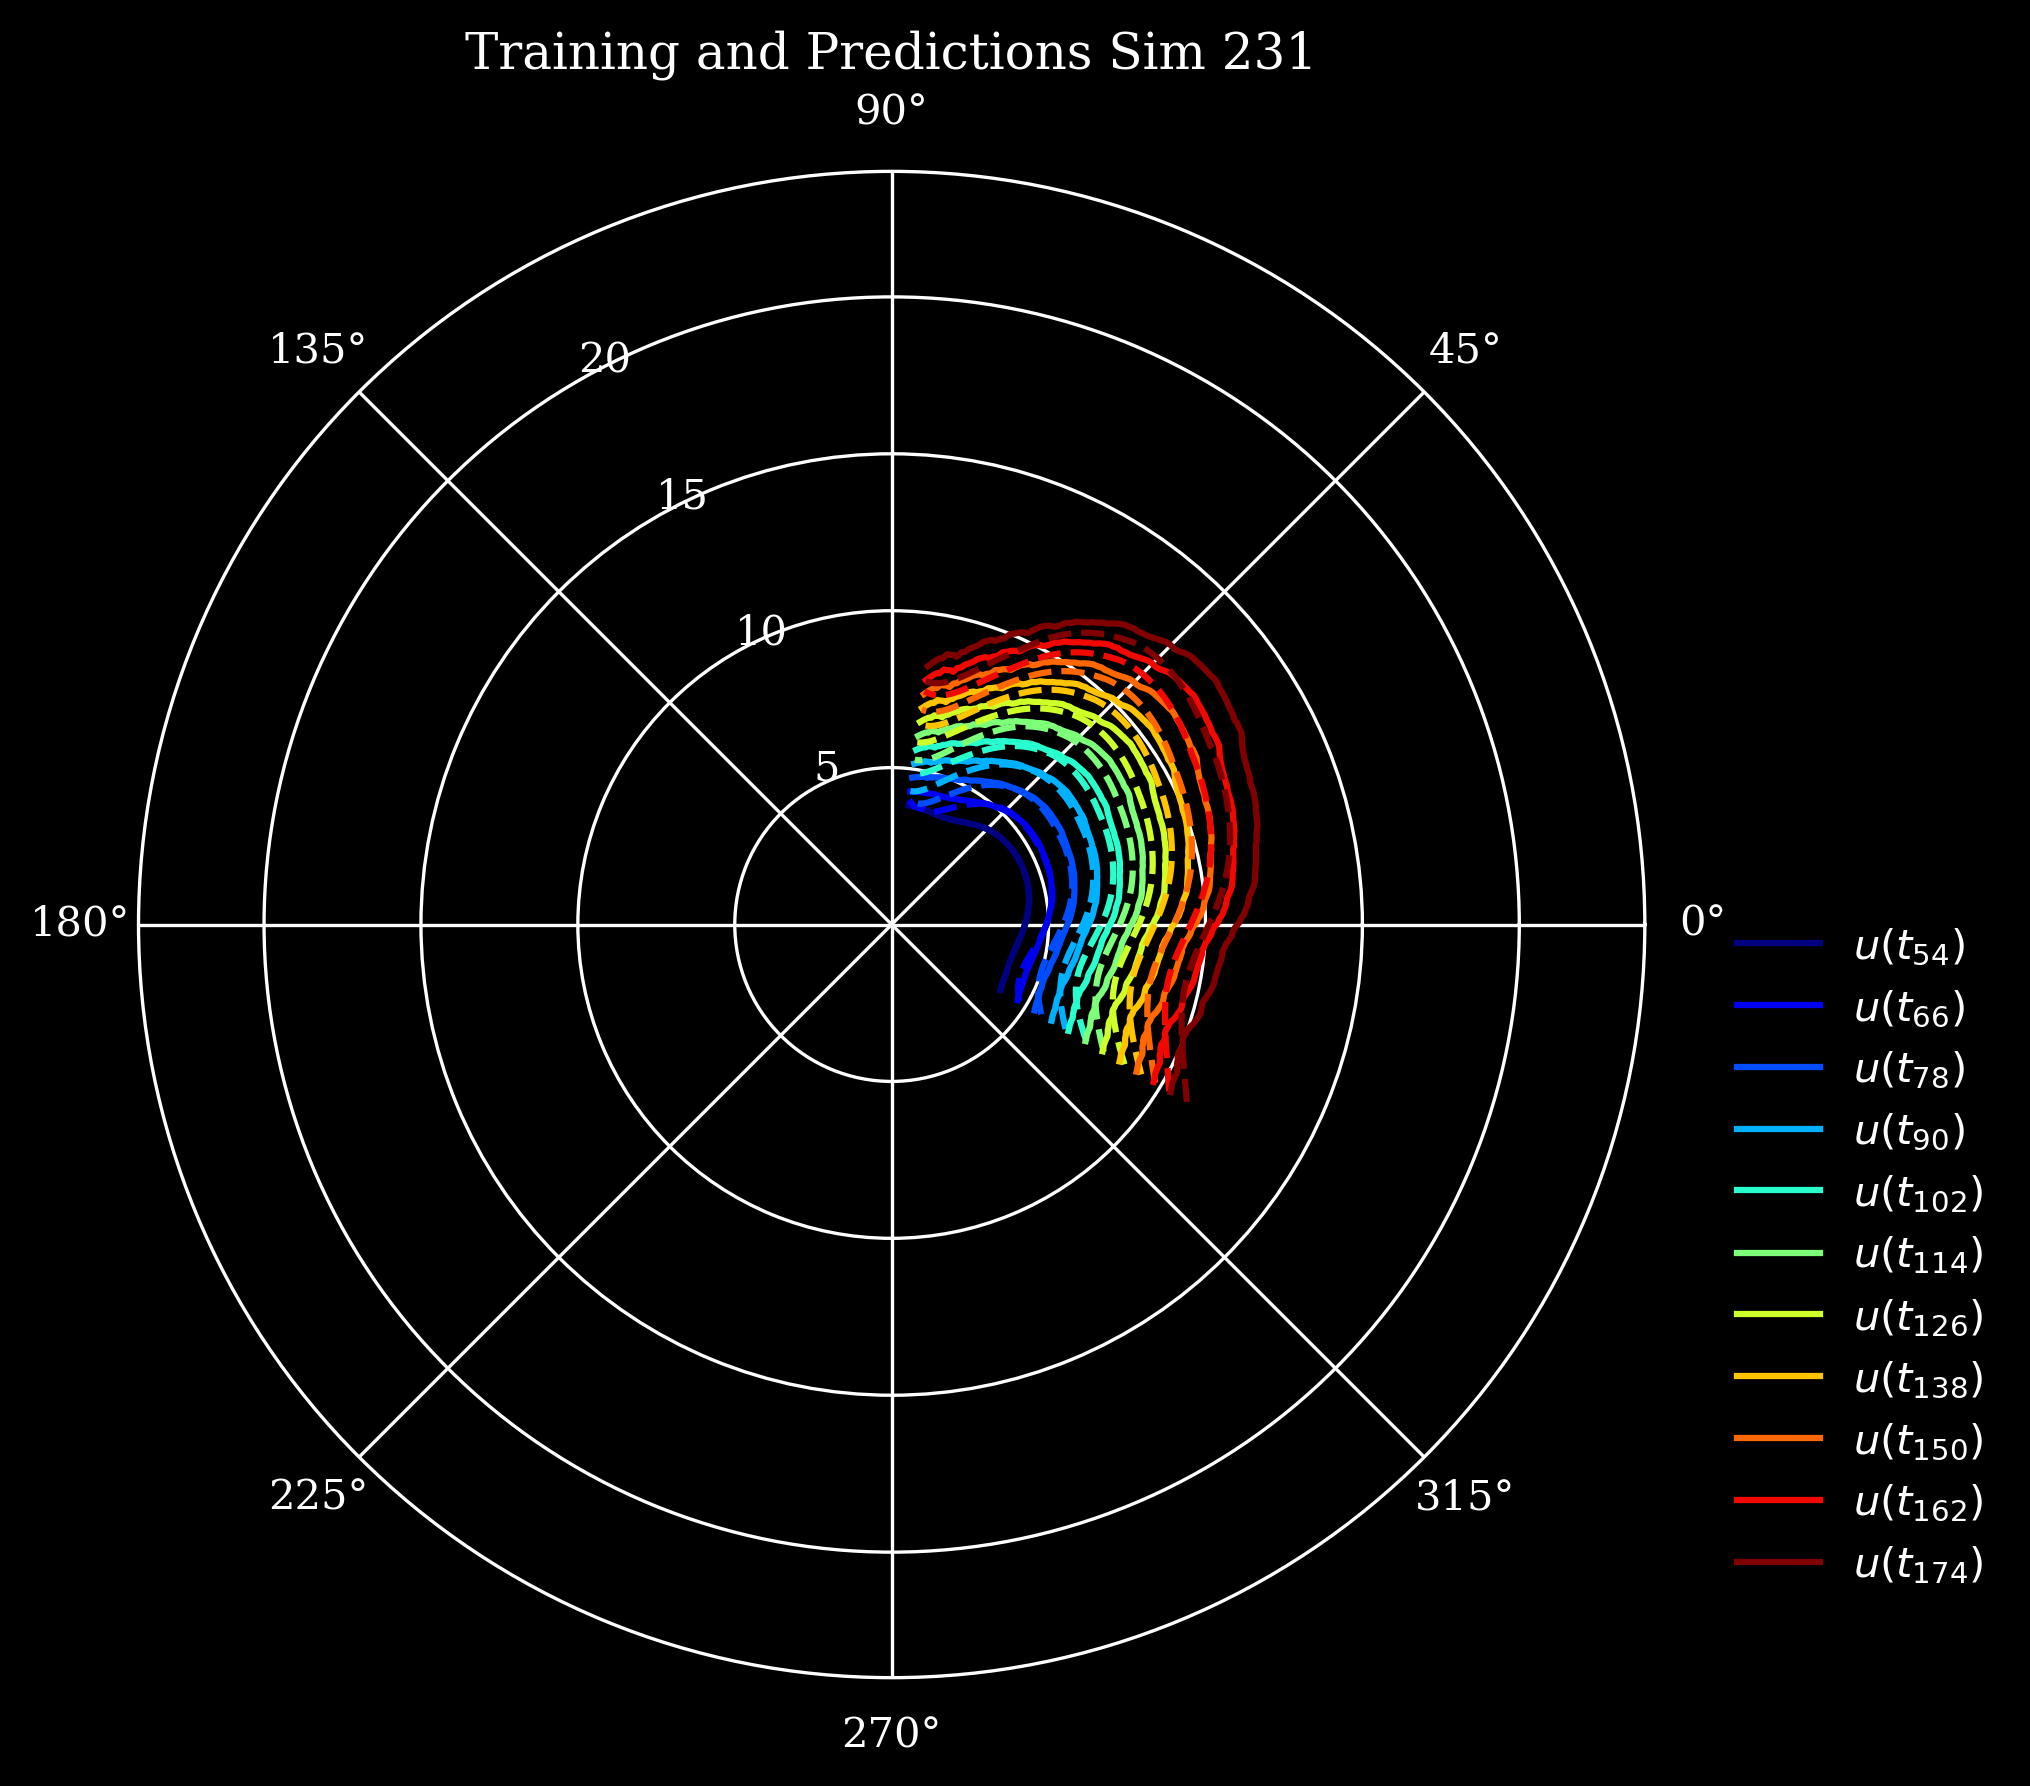

In [140]:
edut.plotTrainPredData1Model(pred_y_pnode_final_231.cpu().numpy(), y_true_231.cpu().numpy(), ed_2161, sd_2161, simIdx=186)

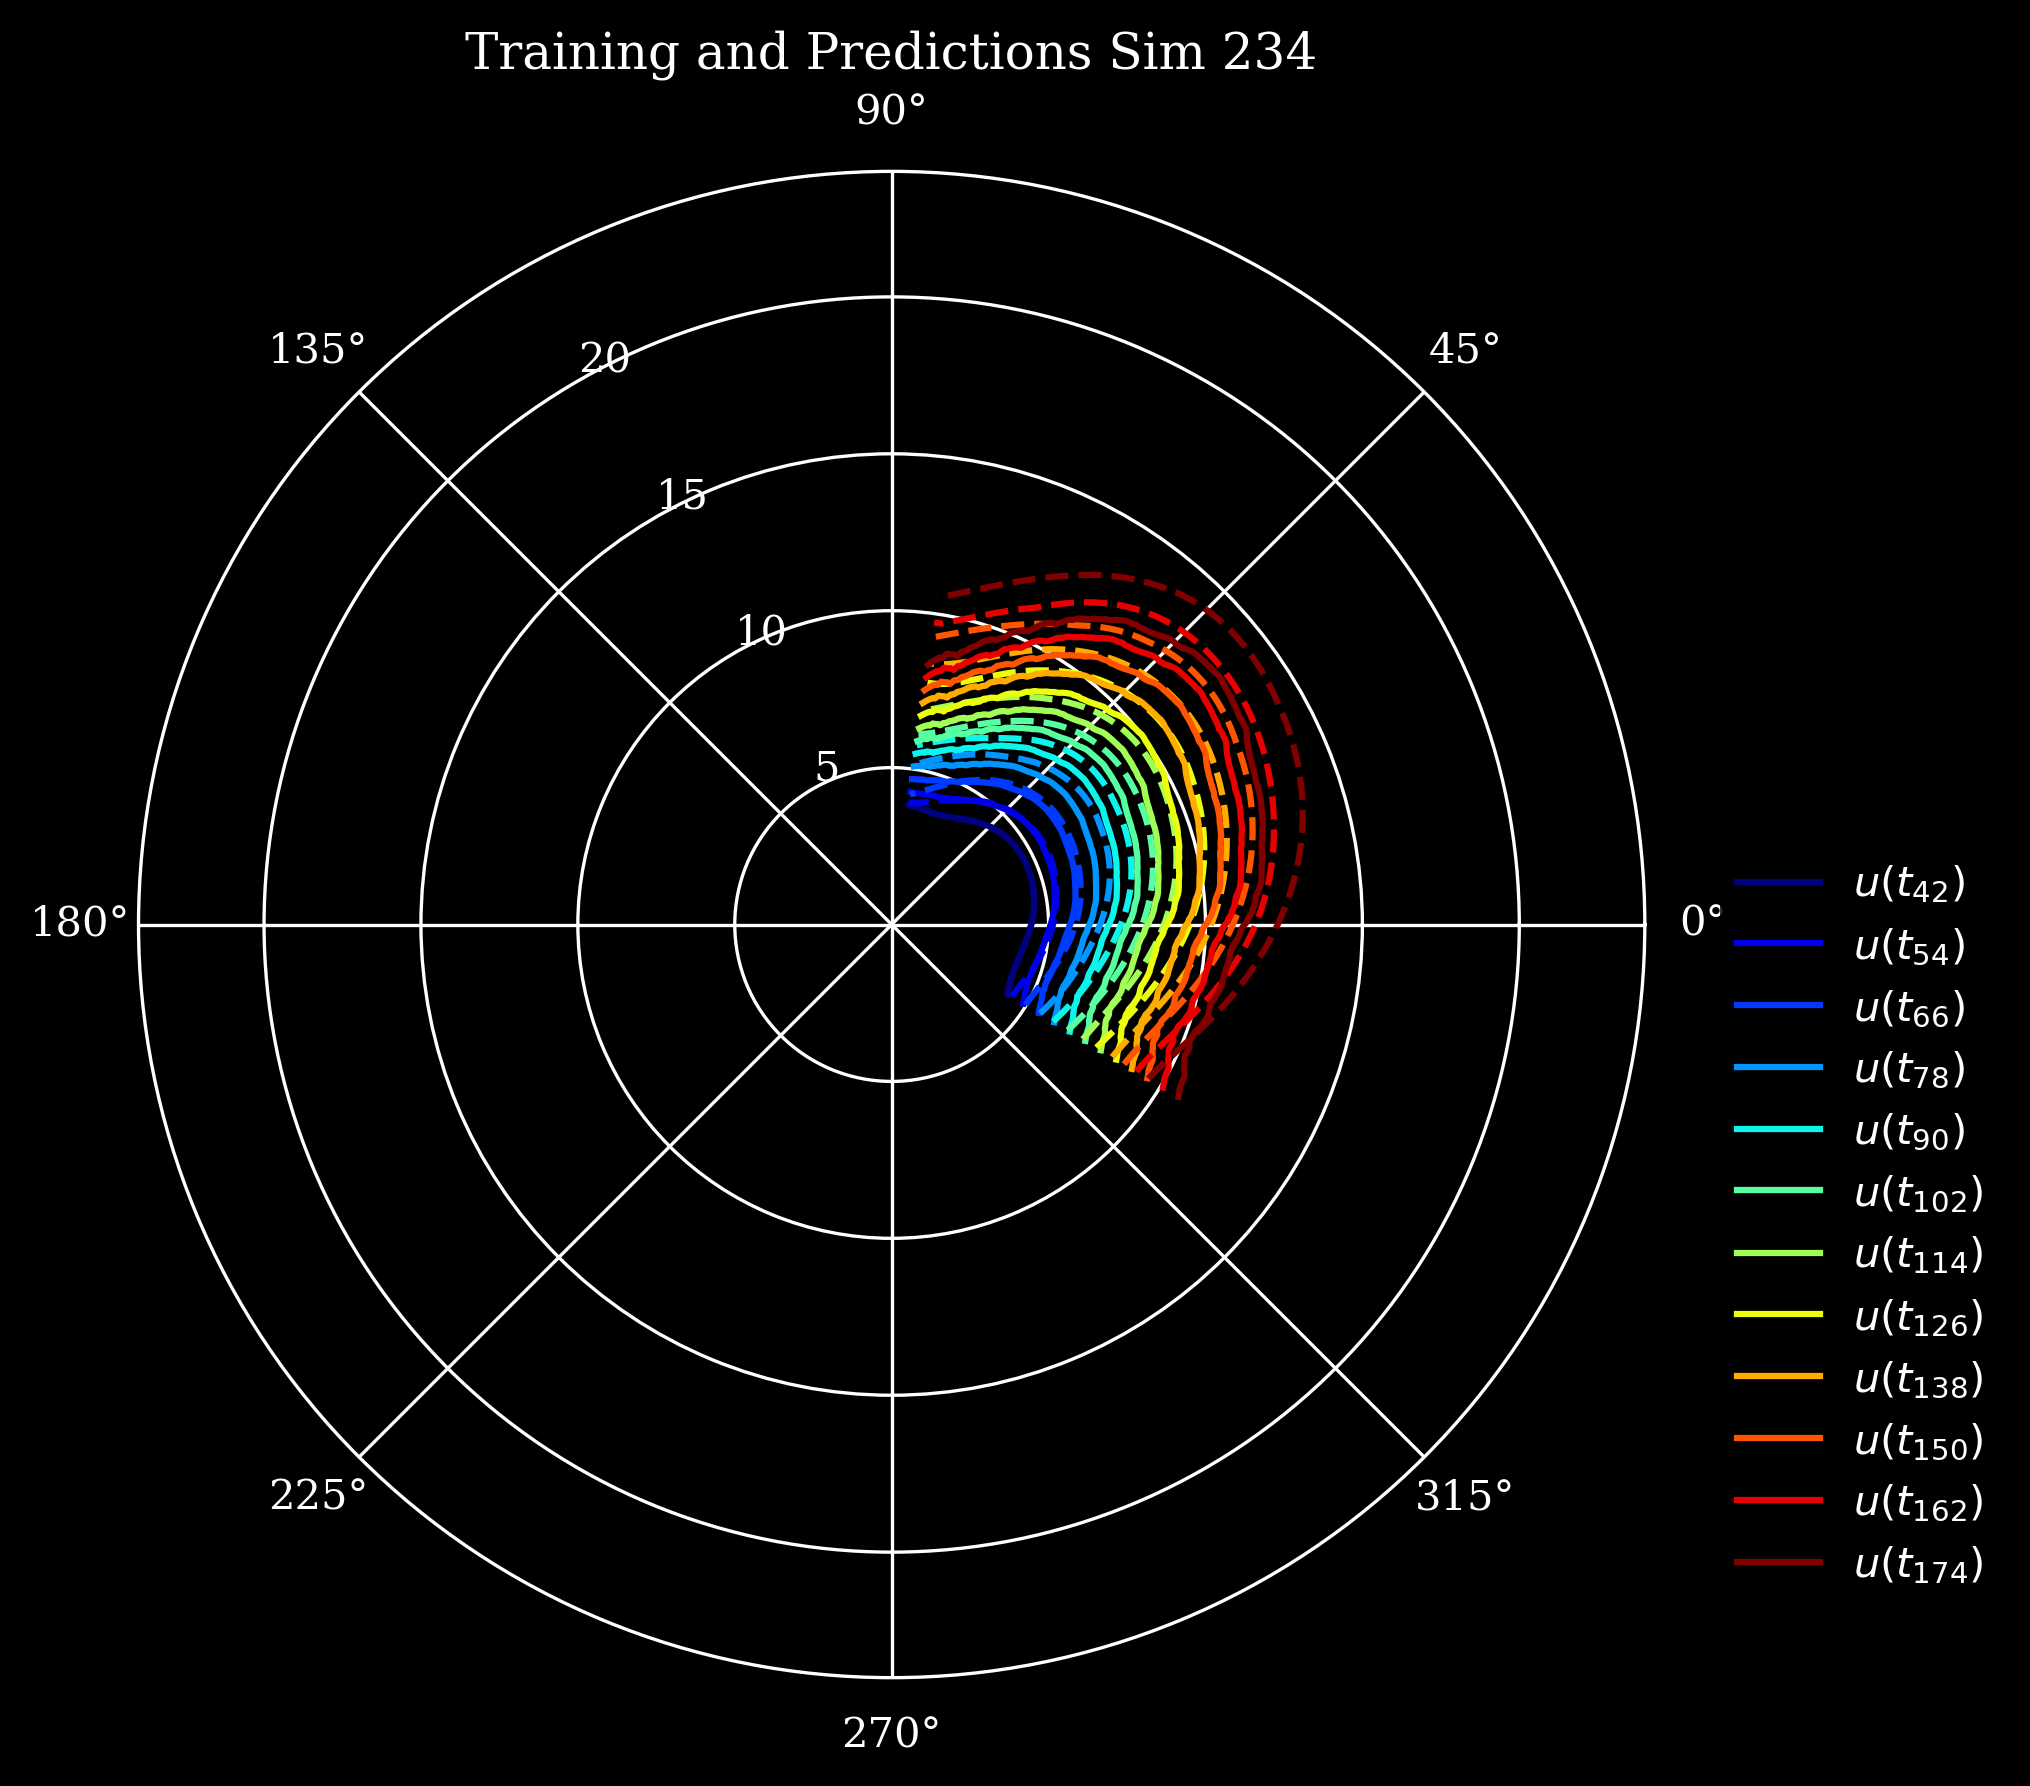

In [141]:
edut.plotTrainPredData1Model(pred_y_pnode_final_234.cpu().numpy(), y_true_234.cpu().numpy(), ed_2161, sd_2161, simIdx=189)

In [153]:
# all_losses = np.loadtxt("./losses_tc2_globalNODE.txt")
all_losses = np.loadtxt("./losses_tc2_globalNODE_CORRECT.txt")

In [154]:
all_losses.shape

(200, 2)

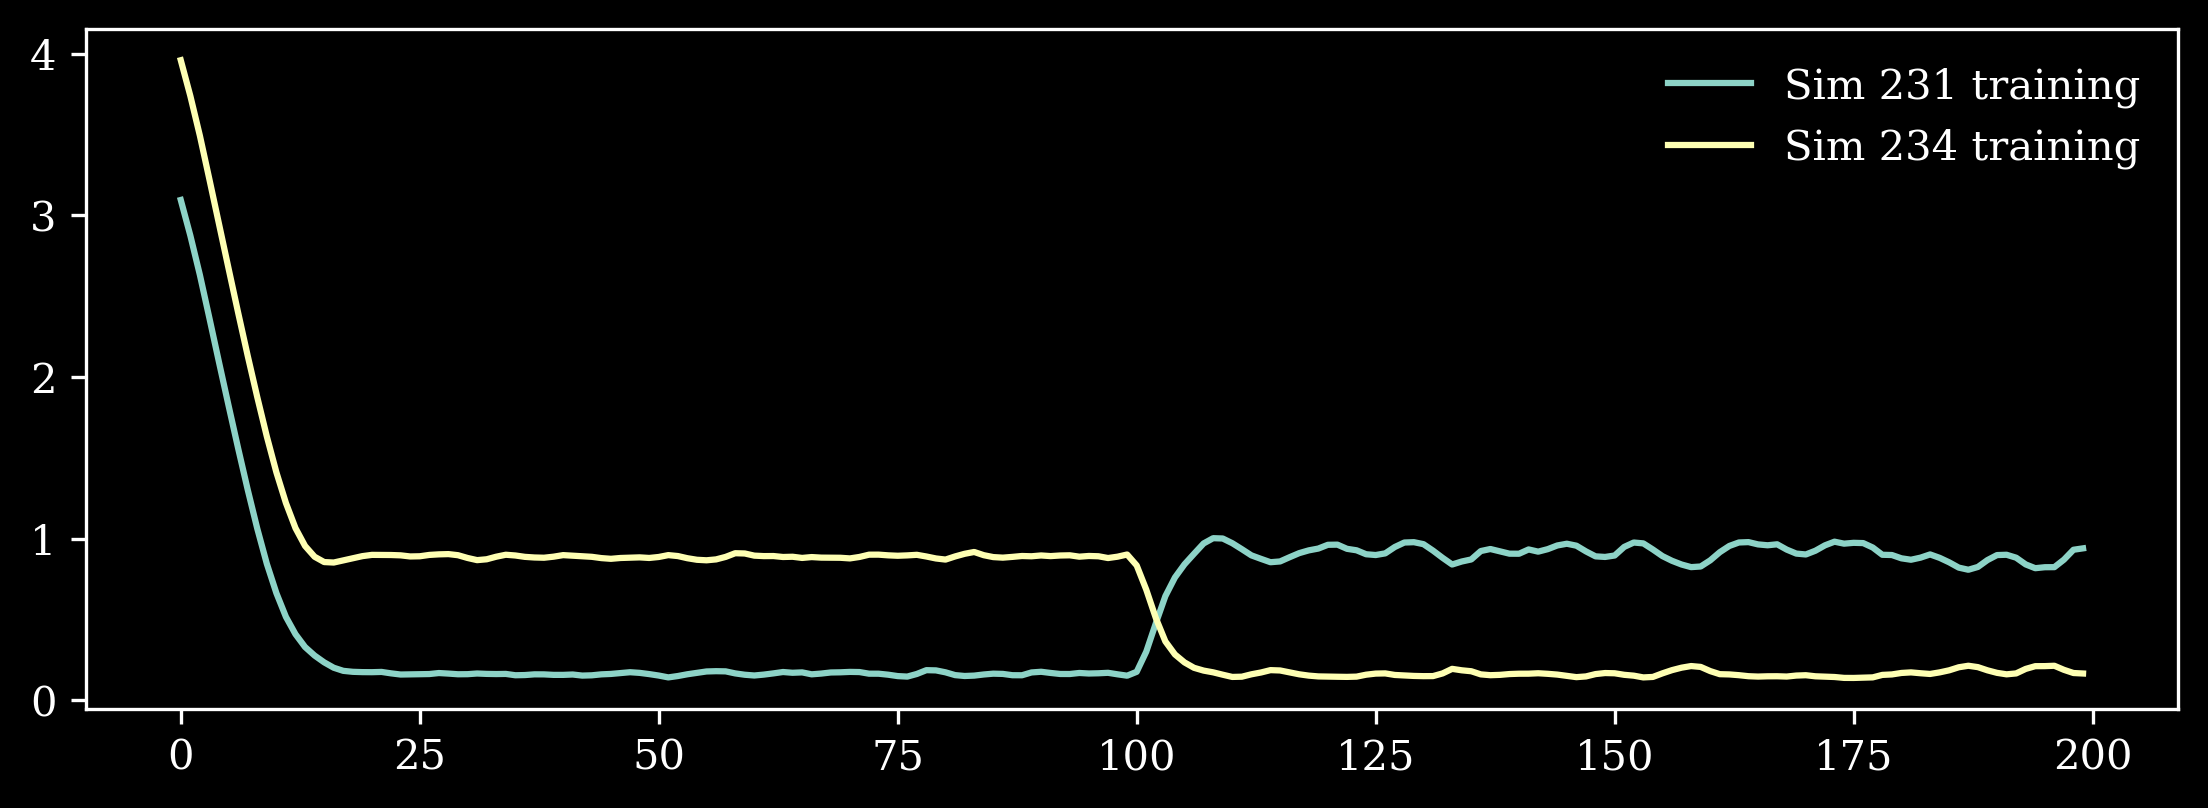

In [155]:
plt.plot(all_losses[:, 0], label="Sim 231 training")
plt.plot(all_losses[:, 1], label="Sim 234 training")
plt.legend()

In [ ]:
# plot results

#### Try with all sims, it can't hurt!!!

In [ ]:
def getAbsoluteAvgBatchLoss(prediction_tensor, target_tensor):
    """
    both tensors are of dims (n_times, n_batch, 1, len_traj) or (n_times, 1, len_traj)
    """
    
    # swap dimensions of batch and time
    if len(prediction_tensor.shape) > 3:
        prediction_tensor = torch.permute(prediction_tensor, (1, 0, 2, 3))
        target_tensor = torch.permute(target_tensor, (1, 0, 2, 3))
        # print(prediction_tensor.shape)#testing
        # get torch.abs of difference
        abs_diff = torch.abs(prediction_tensor - target_tensor)

        # sum over trajectory length
        batch_sums = torch.sum(abs_diff, 3)
    else:
        prediction_tensor = torch.permute(prediction_tensor, (1, 0, 2))
        target_tensor = torch.permute(target_tensor, (1, 0, 2))
        # print(prediction_tensor.shape)#testing
        # get torch.abs of difference
        abs_diff = torch.abs(prediction_tensor - target_tensor)

        # sum over trajectory length
        batch_sums = torch.sum(abs_diff, 2)


    # print(batch_sums.shape)  #testing
    
    # get mean of final tensor to get batch and time averaged absolute loss
    batch_loss = torch.mean(batch_sums)
    
    # print(batch_loss)#testing
    
    return batch_loss

In [ ]:
niters = 400
test_freq = 5

In [ ]:
len(sd_train)

In [ ]:
import logging

# stealing this from: 
# https://github.com/rtqichen/torchdiffeq/blob/master/examples/odenet_mnist.py#L250C1-L274C18
def get_logger(logpath, package_files=[], displaying=True, saving=True, debug=False):
    logger = logging.getLogger()
    if debug:
        level = logging.DEBUG
    else:
        level = logging.INFO
    logger.setLevel(level)
    if saving:
        info_file_handler = logging.FileHandler(logpath, mode="a")
        info_file_handler.setLevel(level)
        logger.addHandler(info_file_handler)
    if displaying:
        console_handler = logging.StreamHandler()
        console_handler.setLevel(level)
        logger.addHandler(console_handler)
        #     logger.info(filepath)

        #     with open(filepath, "r") as f:
        #         logger.info(f.read())

        #     for f in package_files:
        #         logger.info(f)
        #         with open(f, "r") as package_f:
        #             logger.info(package_f.read())

    return logger

In [ ]:
logger = get_logger(logpath=os.path.join(os.getcwd(), "combined_nn_training.log"))

In [ ]:
func = ODEFuncNet(input_dim, param_dim).to(device)
optimizer = optim.Adam(func.parameters(), lr=1e-3)

In [ ]:
logger.info(func)
# logger.info("Number of parameters: {}".format(count_parameters(func)))

**Thoughts**: We should probably take an average over the entire training set i.e. do loss update and every pre-set number of iterations, check loss on all sims in training set integrated from IC, and use that as benchmark.
As more sims are fed in, the overall error over all sims should reduce, use mean absolute error instead of our function (faster). Also, its better to let this run on NERSC.

Meta-learning? i.e. train on one simulation, but also do a second update based on performance on other simulations?

$$\theta^{\ast} = \arg \min_{\theta}\mathbb{E}_{\mathcal{D} \sim p(\mathcal{D})} \mathcal{L}_{\theta}(\mathcal{D})$$

for the meta-learning case, should we simply attempt to include multiple ICs in one training batch, and possibly all remaining ICs for the meta-update? they can be sampled each time along the lines of https://lilianweng.github.io/posts/2018-11-30-meta-learning/train-meta-learner.png

In [ ]:
for sid in sd_train:
    chosen_sim = sid
    y0_train_torch, y_train_torch, y_full_torch, t_train_torch, t_scaled_torch, sim_index = getDataForSim(ed_2161,
                                                                                                          augmented_r,
                                                                                                          sd_2161,
                                                                                                          chosen_sim)
    
    logger.info("Running {} for Sim {}".format(niters, chosen_sim))
    for itr in range(1, niters + 1):
        optimizer.zero_grad()


        batch_y0, batch_t, batch_y = get_batch(y_train_torch, t_train_torch)

        func.set_params(torch.tensor(np.expand_dims(np.float32(cme_params_norm.loc[chosen_sim - 30 - 1].to_numpy()), axis=(0, 1))))

        pred_y = torch.zeros_like(batch_y)

        for i in range(batch_size):
            pred_y[:, i, :, :] = torch.squeeze(odeint(func, batch_y0[[i], :, :], batch_t[i, :]), 1).to(device)

        loss = getLossAllTrainSims(pred_y, batch_y)
        loss.backward()
        optimizer.step()


        if itr % test_freq == 0:
            with torch.no_grad():
                func.set_params(torch.tensor(np.expand_dims(np.float32(cme_params_norm.loc[chosen_sim - 30 - 1].to_numpy()), axis=(0, 1))))
                pred_y_full_series = odeint(func, 
                                            torch.unsqueeze(y0_train_torch, 0), 
                                            t_scaled_torch)

                loss_full_series = getAbsoluteAvgBatchLoss(torch.squeeze(pred_y_full_series, 1),
                                                           y_full_torch)
                logger.info("Iter {:04d} | Total Loss {:.6f} | Sim {:03d} ".format(itr,
                                                                loss_full_series.item(), 
                                                                chosen_sim))

        end = time.time()

In [ ]:
# chosen_sim = np.random.choice(sd_train)
# y0_train_torch,y_train_torch,y_full_torch,t_train_torch,t_scaled_torch, sim_index = getDataForSim(ed_2161,
#                                                                                                   augmented_r,
#                                                                                                   sd_2161,
#                                                                                                   chosen_sim)
# batch_y0, batch_t, batch_y = get_batch(y_train_torch, t_train_torch)                                                                                                     

In [ ]:
# def getParamsTorch(param_series, n_repeats):
#     """
#     param_series is a row from dataframe in pd. Series shape which we convert to torch tensor of suitable dims
#     """
#     return torch.from_numpy(np.float32(np.expand_dims(np.repeat(np.expand_dims(param_series.to_numpy(), axis=0), n_repeats, axis=0), axis=1)))

In [ ]:
# getParamsTorch(cme_params_norm.loc[chosen_sim - 30 - 1], 10).shape

In [ ]:
import os
import numpy as np

In [ ]:
scratch_dir = os.environ["PSCRATCH"]
trained_models = os.path.join(scratch_dir, "trained_models_1d_edge")

In [ ]:
sd_train = np.load(os.path.join(scratch_dir, trained_models, "sd_train.npy"))
sd_test  = np.load(os.path.join(scratch_dir, trained_models, "sd_test.npy"))
sd_calib = np.load(os.path.join(scratch_dir, trained_models, "sd_calib.npy"))

In [ ]:
sd_calib